# Import the package

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from imutils import paths
import seaborn as sns

import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from keras import regularizers
from keras import metrics
from keras import backend as K


from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

# Data Processing

In [2]:
# constant variable

In [3]:
PATH = '/Users/jade/Desktop/archive/images_compressed'
IMAGE_SIZE = (224, 224)  #original size

In [4]:
print(f"There are {len(os.listdir(PATH))} images in training set!")

There are 5762 images in training set!


In [5]:
data = pd.read_csv('/Users/jade/Desktop/archive/images.csv')
data['image'] = data['image']+'.jpg'
data

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22.jpg,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018.jpg,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d.jpg,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa.jpg,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0.jpg,189,Shoes,False
...,...,...,...,...
5398,dfd4079d-967b-4b3e-8574-fbac11b58103.jpg,204,Shorts,False
5399,befa14be-8140-4faf-8061-1039947e329d.jpg,204,Body,True
5400,5379356a-40ee-4890-b416-2336a7d84061.jpg,310,Shorts,False
5401,65507fb8-3456-4c15-b53e-d1b03bf71a59.jpg,204,Shoes,False


In [6]:
data.isnull().sum()

image        0
sender_id    0
label        0
kids         0
dtype: int64

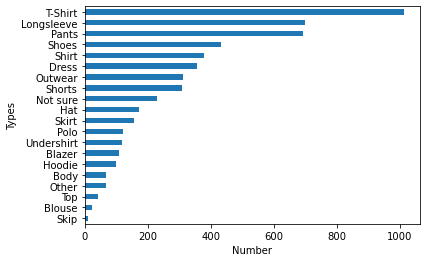

In [7]:
figure = plt.figure()
data.label.value_counts().sort_values().plot(kind='barh')
plt.xlabel('Number')
plt.ylabel('Types')
plt.show()

In [8]:
#Drop some useless classes
labels_to_remove = ['Skip', 'Not sure', 'Other', 'Blouse']
data = data[~data['label'].isin(labels_to_remove)]

In [9]:
def show_random_training_image():
    random_index = random.choice(data.index)
    img_path = data['image'][random_index]
    label = data['label'][random_index]
    complete_path = PATH + '/' + img_path
    image = cv2.imread(complete_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title(label)

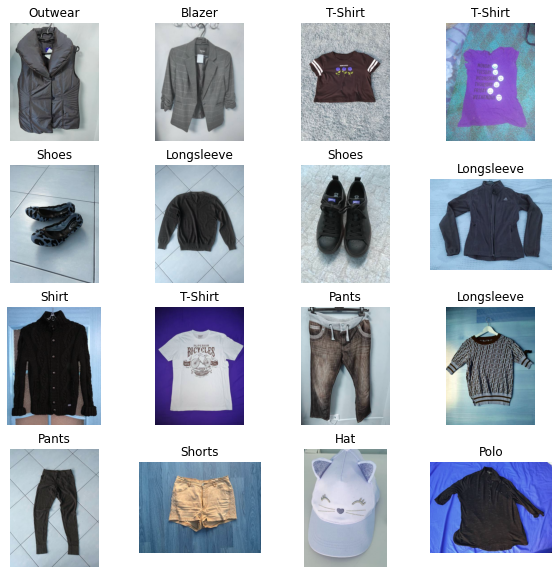

In [10]:
plt.figure(figsize=(10, 10))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    show_random_training_image()

In [11]:
DATA = data[['image','label']]
DATA.index = range(len(DATA))
DATA

,image,label
0,ea7b6656-3f84-4eb3-9099-23e623fc1018.jpg,T-Shirt
1,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa.jpg,T-Shirt
2,3b86d877-2b9e-4c8b-a6a2-1d87513309d0.jpg,Shoes
3,5d3a1404-697f-479f-9090-c1ecd0413d27.jpg,Shorts
4,b0c03127-9dfb-4573-8934-1958396937bf.jpg,Shirt
...,...,...
5068,dfd4079d-967b-4b3e-8574-fbac11b58103.jpg,Shorts
5069,befa14be-8140-4faf-8061-1039947e329d.jpg,Body
5070,5379356a-40ee-4890-b416-2336a7d84061.jpg,Shorts
5071,65507fb8-3456-4c15-b53e-d1b03bf71a59.jpg,Shoes


In [12]:
unique_type = DATA['label'].unique().tolist()
total_calsses = len(unique_type)
print(unique_type)
print(total_calsses)

['T-Shirt', 'Shoes', 'Shorts', 'Shirt', 'Pants', 'Skirt', 'Top', 'Outwear', 'Dress', 'Body', 'Longsleeve', 'Undershirt', 'Hat', 'Polo', 'Hoodie', 'Blazer']
16


In [13]:
DATA['number_label'] = DATA['label'].apply(lambda x:unique_type.index(x)
                                          if x in unique_type else 0)
DATA

<ipython-input-13-943f217ccfae>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATA['number_label'] = DATA['label'].apply(lambda x:unique_type.index(x)


,image,label,number_label
0,ea7b6656-3f84-4eb3-9099-23e623fc1018.jpg,T-Shirt,0
1,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa.jpg,T-Shirt,0
2,3b86d877-2b9e-4c8b-a6a2-1d87513309d0.jpg,Shoes,1
3,5d3a1404-697f-479f-9090-c1ecd0413d27.jpg,Shorts,2
4,b0c03127-9dfb-4573-8934-1958396937bf.jpg,Shirt,3
...,...,...,...
5068,dfd4079d-967b-4b3e-8574-fbac11b58103.jpg,Shorts,2
5069,befa14be-8140-4faf-8061-1039947e329d.jpg,Body,9
5070,5379356a-40ee-4890-b416-2336a7d84061.jpg,Shorts,2
5071,65507fb8-3456-4c15-b53e-d1b03bf71a59.jpg,Shoes,1


In [14]:
#hope to balance data distribution

In [15]:
number = DATA.number_label.value_counts().sort_values()
labels_dict = dict(number)
print(labels_dict)
#the smallest class only has 43 images

{6: 43, 9: 69, 14: 100, 15: 109, 11: 118, 13: 120, 5: 155, 12: 171, 2: 308, 7: 312, 8: 357, 3: 378, 1: 431, 4: 692, 10: 699, 0: 1011}


In [16]:
import math

def get_class_weight(labels_dict):
    total = sum(labels_dict.values())
    max_num = max(labels_dict.values())
    mu = 1/(total/max_num)
    class_weight = dict()
    for key,value in labels_dict.items():
        score = math.log(mu*total/float(value))
        class_weight[key] = score if score>1.0 else 0.5
    
    return class_weight

class_weight = get_class_weight(labels_dict)
print(class_weight)

{6: 3.1574951033269087, 9: 2.684588714423212, 14: 2.3135250330323798, 15: 2.2273473367913277, 11: 2.1480105945548065, 13: 2.1312034762384253, 5: 1.8752701021012246, 12: 1.7770316625178115, 2: 1.1885954360468969, 7: 1.1756920312109889, 8: 1.0409594372408322, 3: 0.5, 1: 0.5, 4: 0.5, 10: 0.5, 0: 0.5}


In [58]:
def getData(start,stop):
    x_data = []
    y_data = []
    
    for i in range(start, stop):
        image_path=PATH +'/'+ DATA.loc[i,'image']
        image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
        resized_img = cv2.resize(image,dsize=(50,50))
        x_data.append(resized_img)
        
        y_values = DATA.loc[i,'number_label']
        y_data.append(y_values)
        
    return x_data,y_data

In [68]:
X=[]
Y=[]


start = 0
stop = len(DATA)

X,Y=getData(start,stop)

In [69]:
print(type(X))
print(X[0])

<class 'list'>
[[140 142 140 ... 143 145 141]
 [142 138 146 ... 147 142 139]
 [147 149 154 ... 143 143 134]
 ...
 [169 166 169 ... 176 175 176]
 [166 172 171 ... 175 177 179]
 [168 165 164 ... 174 165 150]]


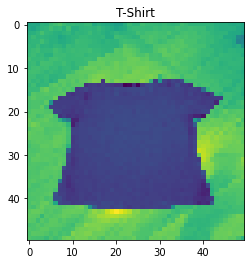

In [70]:
plt.imshow(X[0])
plt.title(unique_type[Y[0]])
plt.show()

In [71]:
X = np.array(X).reshape(-1,50,50,1)
Y = np.array(Y)

In [72]:
X = X/255.0
Y = Y.reshape(len(X),)

In [73]:
print(X.shape)
print(Y.shape)

(5073, 50, 50, 1)
(5073,)


# Bulid the model

In [65]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5)

In [66]:
print('Train Image Data Shape: ',X_train.shape)
print('Train Label Data Shape: ',Y_train.shape)
print('Test Image Data Shape: ',X_test.shape)
print('Test Label Data Shape: ',Y_test.shape)

Train Image Data Shape:  (1, 50, 50, 1)
Train Label Data Shape:  (1,)
Test Image Data Shape:  (2, 50, 50, 1)
Test Label Data Shape:  (2,)


In [67]:
X_train, X_validate, Y_train, Y_validate = train_test_split(X_train, Y_train, test_size = 0.5)

ValueError: With n_samples=1, test_size=0.5 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [27]:
print('Train Image Data Shape: ',X_train.shape)
print('Train Label Data Shape: ',Y_train.shape)
print('Validation Image Data Shape: ',X_validate.shape)
print('Validation Label Data Shape: ',Y_validate.shape)

Train Image Data Shape:  (1268, 50, 50, 1)
Train Label Data Shape:  (1268,)
Validation Image Data Shape:  (1268, 50, 50, 1)
Validation Label Data Shape:  (1268,)


## CNN model

In [28]:
def build_model():
    model = keras.Sequential()
    model.add(Conv2D(32, (1, 3),padding="valid", input_shape = (50, 50, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (2, 3), input_shape = (50, 50, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3, 3), input_shape = (50, 50, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(units = 512, activation = 'relu',
                    kernel_regularizer=regularizers.l2(0.01)
                    ))
    model.add(Dropout(0.35))
    model.add(Dense(units = 16, activation = 'softmax',activity_regularizer=regularizers.l1(0.01)))
    
    model.compile(loss ='sparse_categorical_crossentropy',
                  optimizer='adam',metrics =['accuracy','mse']
                  )
    
    return model

In [29]:
model = build_model()

In [30]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 48, 32)        128       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 24, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 25, 24, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 22, 64)        12352     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 11, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 12, 11, 64)        0

In [31]:
history = model.fit(X_train, Y_train, 
                    epochs = 150, verbose = 1, 
                    validation_data = (X_validate, Y_validate),
                   class_weight=class_weight)

Epoch 1/150
40/40 [==============================] - 3s 59ms/step - loss: 6.1065 - accuracy: 0.1080 - mse: 45.2109 - val_loss: 3.5788 - val_accuracy: 0.2074 - val_mse: 45.3690
Epoch 2/150
40/40 [==============================] - 2s 55ms/step - loss: 2.7922 - accuracy: 0.1601 - mse: 45.2110 - val_loss: 2.8755 - val_accuracy: 0.2216 - val_mse: 45.3690
Epoch 3/150
40/40 [==============================] - 2s 57ms/step - loss: 2.4945 - accuracy: 0.2145 - mse: 45.2109 - val_loss: 2.7482 - val_accuracy: 0.2098 - val_mse: 45.3691
Epoch 4/150
40/40 [==============================] - 3s 64ms/step - loss: 2.3889 - accuracy: 0.2374 - mse: 45.2118 - val_loss: 2.4794 - val_accuracy: 0.3178 - val_mse: 45.3712
Epoch 5/150
40/40 [==============================] - 3s 67ms/step - loss: 2.2766 - accuracy: 0.3013 - mse: 45.2150 - val_loss: 2.3893 - val_accuracy: 0.3265 - val_mse: 45.3744
Epoch 6/150
40/40 [==============================] - 3s 63ms/step - loss: 2.1694 - accuracy: 0.3588 - mse: 45.2180 - val

40/40 [==============================] - 3s 71ms/step - loss: 1.0215 - accuracy: 0.8076 - mse: 45.2512 - val_loss: 2.4033 - val_accuracy: 0.5331 - val_mse: 45.4020
Epoch 48/150
40/40 [==============================] - 3s 69ms/step - loss: 1.0219 - accuracy: 0.8233 - mse: 45.2517 - val_loss: 2.5756 - val_accuracy: 0.4953 - val_mse: 45.4014
Epoch 49/150
40/40 [==============================] - 3s 69ms/step - loss: 1.0214 - accuracy: 0.8304 - mse: 45.2517 - val_loss: 2.4731 - val_accuracy: 0.5150 - val_mse: 45.4016
Epoch 50/150
40/40 [==============================] - 3s 69ms/step - loss: 1.0483 - accuracy: 0.8147 - mse: 45.2511 - val_loss: 2.3982 - val_accuracy: 0.5110 - val_mse: 45.3995
Epoch 51/150
40/40 [==============================] - 3s 69ms/step - loss: 1.0016 - accuracy: 0.8407 - mse: 45.2508 - val_loss: 2.4971 - val_accuracy: 0.5213 - val_mse: 45.4025
Epoch 52/150
40/40 [==============================] - 3s 68ms/step - loss: 0.9965 - accuracy: 0.8391 - mse: 45.2528 - val_loss: 

40/40 [==============================] - 3s 67ms/step - loss: 0.8875 - accuracy: 0.8809 - mse: 45.2558 - val_loss: 2.6233 - val_accuracy: 0.5457 - val_mse: 45.4058
Epoch 94/150
40/40 [==============================] - 3s 71ms/step - loss: 0.9148 - accuracy: 0.8825 - mse: 45.2558 - val_loss: 2.6528 - val_accuracy: 0.5315 - val_mse: 45.4063
Epoch 95/150
40/40 [==============================] - 3s 68ms/step - loss: 0.8843 - accuracy: 0.8920 - mse: 45.2572 - val_loss: 2.7729 - val_accuracy: 0.5166 - val_mse: 45.4059
Epoch 96/150
40/40 [==============================] - 3s 65ms/step - loss: 0.9730 - accuracy: 0.8699 - mse: 45.2567 - val_loss: 2.6921 - val_accuracy: 0.5284 - val_mse: 45.4051
Epoch 97/150
40/40 [==============================] - 3s 68ms/step - loss: 0.9680 - accuracy: 0.8920 - mse: 45.2560 - val_loss: 2.7104 - val_accuracy: 0.5300 - val_mse: 45.4048
Epoch 98/150
40/40 [==============================] - 3s 64ms/step - loss: 0.9240 - accuracy: 0.8888 - mse: 45.2569 - val_loss: 

40/40 [==============================] - 3s 69ms/step - loss: 0.7740 - accuracy: 0.9046 - mse: 45.2587 - val_loss: 2.6469 - val_accuracy: 0.5213 - val_mse: 45.4064
Epoch 140/150
40/40 [==============================] - 3s 69ms/step - loss: 0.7677 - accuracy: 0.9188 - mse: 45.2591 - val_loss: 2.6731 - val_accuracy: 0.5189 - val_mse: 45.4071
Epoch 141/150
40/40 [==============================] - 3s 67ms/step - loss: 0.7850 - accuracy: 0.9014 - mse: 45.2588 - val_loss: 2.7643 - val_accuracy: 0.5339 - val_mse: 45.4082
Epoch 142/150
40/40 [==============================] - 3s 70ms/step - loss: 0.7848 - accuracy: 0.9172 - mse: 45.2594 - val_loss: 2.7983 - val_accuracy: 0.5158 - val_mse: 45.4078
Epoch 143/150
40/40 [==============================] - 3s 72ms/step - loss: 0.7740 - accuracy: 0.9172 - mse: 45.2593 - val_loss: 2.6843 - val_accuracy: 0.5260 - val_mse: 45.4060
Epoch 144/150
40/40 [==============================] - 3s 70ms/step - loss: 0.8465 - accuracy: 0.8872 - mse: 45.2583 - val_l

# Model Accuracy

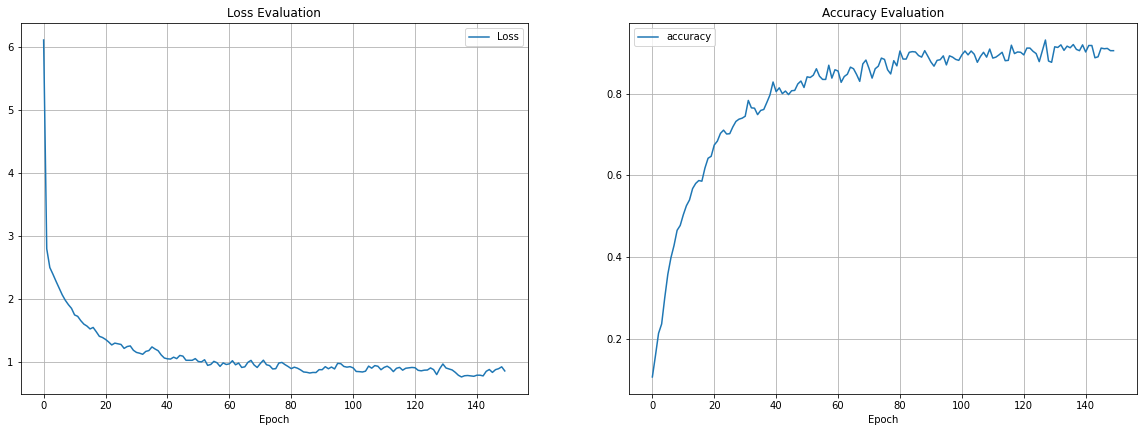

In [32]:
plt.figure(figsize=(20,15))

plt.subplot(2,2,1)
plt.plot(model.history.history['loss'],label='Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.title('Loss Evaluation')

plt.subplot(2,2,2)
plt.plot(model.history.history['accuracy'],label='accuracy')

plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.title('Accuracy Evaluation')

plt.show()

In [33]:
#save and load the model

In [34]:
model.save('fashion_product.h5')

In [35]:
model = models.load_model('fashion_product.h5')

# Model Evaluation

In [36]:
#predict classes

In [37]:
predicted_classes = model.predict(X_test)
classes_x = np.argmax(predicted_classes,axis=1)

80/80 [==============================] - 1s 13ms/step


In [38]:
# test data evaluation

In [39]:
evl = model.evaluate(X_test,Y_test,batch_size =128)
print('test loss:{}'.format(evl[0]))
print('test accuracy:{}'.format(evl[1]))
print('mse:{}'.format(evl[2]))

20/20 [==============================] - 1s 45ms/step - loss: 2.7571 - accuracy: 0.5416 - mse: 47.4704
test loss:2.757120132446289
test accuracy:0.5415845513343811
mse:47.470420837402344


In [40]:
#for train data

In [41]:
pre_train = model.predict(X_train)
pretrain = np.argmax(pre_train,axis=1)
train_acc = accuracy_score(Y_train,pretrain)
train_acc

40/40 [==============================] - 1s 15ms/step


0.9952681388012619

In [42]:
print(classification_report(Y_train,pretrain))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       239
           1       0.99      1.00      1.00       128
           2       1.00      1.00      1.00        85
           3       0.99      1.00      0.99        93
           4       1.00      1.00      1.00       185
           5       1.00      1.00      1.00        30
           6       0.89      1.00      0.94         8
           7       1.00      1.00      1.00        73
           8       0.99      0.99      0.99        83
           9       1.00      1.00      1.00        12
          10       1.00      0.99      0.99       177
          11       1.00      1.00      1.00        33
          12       0.95      1.00      0.98        42
          13       1.00      1.00      1.00        38
          14       1.00      1.00      1.00        22
          15       1.00      1.00      1.00        20

    accuracy                           1.00      1268
   macro avg       0.99   

In [43]:
#for test data

In [44]:
test_acc = accuracy_score(Y_test,classes_x )
test_acc

0.5415845486795428

In [45]:
print(classification_report(Y_test,classes_x ))

              precision    recall  f1-score   support

           0       0.63      0.69      0.66       509
           1       0.60      0.81      0.69       210
           2       0.49      0.51      0.50       140
           3       0.42      0.44      0.43       191
           4       0.83      0.81      0.82       327
           5       0.38      0.26      0.31        81
           6       0.17      0.08      0.11        26
           7       0.38      0.36      0.37       166
           8       0.48      0.52      0.50       188
           9       0.65      0.37      0.47        41
          10       0.49      0.47      0.48       341
          11       0.24      0.19      0.21        59
          12       0.43      0.41      0.42        85
          13       0.16      0.28      0.21        53
          14       0.47      0.15      0.22        55
          15       0.37      0.17      0.23        65

    accuracy                           0.54      2537
   macro avg       0.45   

In [46]:
#confusion matrix

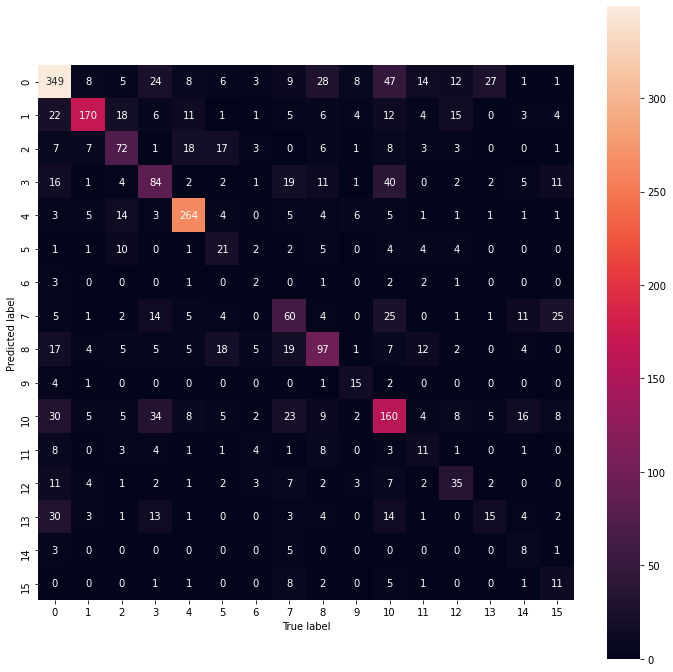

In [47]:
plt.figure(figsize=(12,12))
cm = confusion_matrix(Y_test,classes_x )
sns.heatmap(cm.T,square=True,annot=True,fmt='d')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

In [48]:
#image label prediction

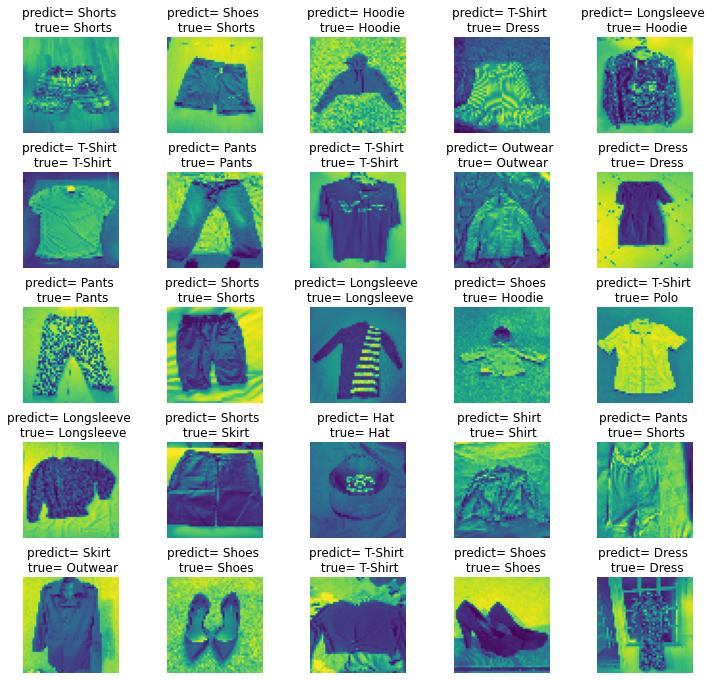

In [49]:
fig, axes = plt.subplots(5,5,figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0,25):
    axes[i].imshow(X_test[i].reshape(50,50))
    axes[i].set_title(f"predict= {unique_type[classes_x[i]]} \n true= {unique_type[Y_test[i]]}")
    axes[i].axis('off')
    
plt.subplots_adjust(wspace=0.5)

# Check model prediction & Result

In [50]:
def load_image(i,PATH):
    image_path=PATH +'/'+ DATA.loc[i,'image']
    image_id = DATA.loc[i,'image'].split('.')
    res = image_id[0]
    
    image = cv2.imread(image_path,cv2.IMREAD_COLOR)
    resized_img = cv2.resize(image,dsize=(224,224))
    
    return resized_img,res

Text(0.5, 1.0, 'd30de8fc-5550-4c34-8c44-57051407352b')

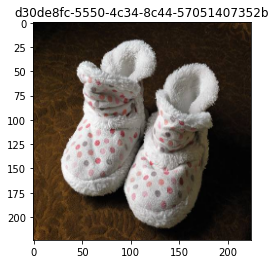

In [51]:
img,img_id = load_image(180,PATH)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title(img_id)

In [52]:
def make_prediction(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    resized_img = cv2.resize(img, dsize=(50, 50))
    
    x_data = np.array(resized_img).reshape(-1, 50,50,1)
    x_data=x_data/255

    result=model.predict(x_data)
    return x_data,unique_type[np.argmax(result)]


In [53]:
numpy_image,result=make_prediction(img)
print('prediction:',result)
print('true:',DATA.loc[180,'label'])

1/1 [==============================] - 0s 27ms/step
prediction: Shoes
true: Shoes


In [54]:
#using another image dataset to check the model

In [55]:
PATH_original = '/Users/jade/Desktop/archive/images_original'

Text(0.5, 1.0, '745b0eb8-f213-4efe-9209-560746347ed3')

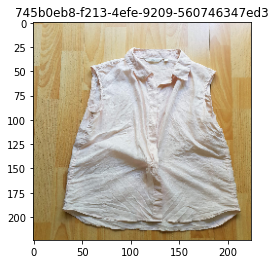

In [56]:
n = random.randint(0,5000)
img1,img_id = load_image(n,PATH_original)
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.title(img_id)

In [57]:
numpy_image,result= make_prediction(img1)
print('prediction:',result)
print('true:',DATA.loc[n,'label'])

1/1 [==============================] - 0s 23ms/step
prediction: T-Shirt
true: Shirt
